# Neural Symplectic Form (SYM)

- Original code from Y. Chen

- Modified by Jae Hoon (Daniel) Lee

In [1]:
import torch
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
import random
solver = scipy.integrate.solve_ivp

seed = 36
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True

In [2]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import pandas as pd

BATCH_size = 1000

dftarget = pd.read_csv("./data/target_dp_sep_sc.csv", header=None, dtype=np.float32)
dfinput = pd.read_csv("./data/input_dp_sep_sc.csv", header=None, dtype=np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(dfinput.values, dftarget.values, test_size=0.2)

# train data
data_train = data_utils.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_size, shuffle=True)

# test data
data_test = data_utils.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_size, shuffle=True)

In [3]:
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class MLPC(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLPC, self).__init__()
    self.l1 = nn.Linear(input_size,hidden_size)
    self.l2 = nn.Linear(hidden_size,hidden_size)
    self.l3 = nn.Linear(hidden_size,output_size)
    self.input_size = input_size
  
  def forward(self,x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x
  
  def jac(self, x):
    x = x.requires_grad_(True)
    with torch.enable_grad():
      u = self(x)
      #jac = torch.autograd.functional.jacobian(MLPU.forward(self,x), x, create_graph=True)
      jac = torch.zeros((x.shape[0], self.input_size, self.input_size)).to(device)
      for idx in range(self.input_size):
        jac[:,idx,:] = torch.autograd.grad(u[:,idx].sum(), x, create_graph=True)[0]
    return jac

In [5]:
class hamiltonian(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(hamiltonian,self).__init__()
    self.l1 = nn.Linear(input_size,hidden_size)
    self.l2 = nn.Linear(hidden_size,hidden_size)
    self.l3 = nn.Linear(hidden_size,output_size)
  
  def forward(self,x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x

  def grad(self,x):
    x = x.requires_grad_(True)
    with torch.enable_grad():
      hamiltonian = self(x)
      gradient = torch.autograd.grad(hamiltonian.sum(),x,create_graph=True,retain_graph=True)
    return gradient[0]
    #return hamiltonian

In [6]:
import time
input_size = 4
hidden_size = 200
output_size = 1

num_trials = 10
stats = {'train_loss': [], 'eval_loss': [], 'computation_time': []}

for trial in range(num_trials):
  c_nn = MLPC(input_size, hidden_size, input_size).to(device)
  h_nn = hamiltonian(input_size, hidden_size, output_size).to(device)
  num_epochs = 2000
  criterion = nn.MSELoss()
  parmas = list(c_nn.parameters()) + list(h_nn.parameters())
  optimizer = optim.Adam(params=parmas,lr=0.001 )

  history_loss = []
  history_eval = []
  history_acc = []
  startt = time.time()
  for epoch in range(num_epochs):
    h_nn.train()
    c_nn.train()

    total_loss = 0.0
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(train_loader):
      optimizer.zero_grad()
      x = data.to(device)
      output = h_nn.grad(x)
      jac = c_nn.jac(x)
      jac_t = torch.transpose(jac,1,2)
    
      M_t = jac - jac_t
      M_inv_t = torch.inverse(M_t)


      output = output.unsqueeze(2)
      output = torch.matmul(M_inv_t, output)
      output = output.squeeze(2)
     


      target = target.to(device)

      loss = criterion(output,target)
      loss.backward()
      optimizer.step()

      total_loss = total_loss+loss.cpu().item()
      cnt = cnt + 1
    total_loss = total_loss/cnt
  
    num_correct = 0
    num_data = 0
    h_nn.eval()
    c_nn.eval()
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(test_loader):
      x = data.to(device)
      output = h_nn.grad(x)
      jac = c_nn.jac(x)
     
      jac_t = torch.transpose(jac,1,2)
    
      M_t = jac - jac_t
      M_inv_t = torch.inverse(M_t)


      output = output.unsqueeze(2)
      output = torch.matmul(M_inv_t, output)
      output = output.squeeze(2)
    

      eval_loss = eval_loss+criterion(output,target.to(device)).cpu().item()
      cnt = cnt + 1
    eval_loss = eval_loss/cnt
    history_loss.append(total_loss)
    history_eval.append(eval_loss)
  print("{}/{} training loss:{},evaluation loss:{}".format(epoch+1,num_epochs,total_loss,eval_loss))
  path = "./model/danieljh_sym_c_dp_sep_sc_2t_lr_{}".format(trial)
  torch.save(c_nn.state_dict(), path)
  path = "./model/danieljh_sym_h_dp_sep_sc_2t_lr_{}".format(trial)
  torch.save(h_nn.state_dict(), path)
  stats['train_loss'].append(total_loss)
  stats['eval_loss'].append(eval_loss)
  stats['computation_time'].append(time.time() - startt)

print("train_loss:{}, std: {}".format(np.mean(stats['train_loss']), np.std(stats['train_loss'])))
print("test_loss:{}, std: {}".format(np.mean(stats['eval_loss']), np.std(stats['eval_loss'])))
print("computation_time:{}, std: {}".format(np.mean(stats['computation_time']), np.std(stats['computation_time'])))

2000/2000 training loss:7.586337392240239e-05,evaluation loss:0.00016601740026089828
2000/2000 training loss:0.0001073618674354293,evaluation loss:0.00019692047135322355
2000/2000 training loss:6.855468157027645e-05,evaluation loss:0.00014320859700092114
2000/2000 training loss:0.00012714350937130802,evaluation loss:0.0002457656873957603
2000/2000 training loss:0.00014925606160431926,evaluation loss:0.0003839816217805492
2000/2000 training loss:0.00010131322690085654,evaluation loss:0.0002112513890097034
2000/2000 training loss:6.247254304980743e-05,evaluation loss:0.00017166347006423167
2000/2000 training loss:0.0001670432584887749,evaluation loss:0.00034423243978380923
2000/2000 training loss:5.468626469564697e-05,evaluation loss:0.0001040261578054924
2000/2000 training loss:0.00015124444676075654,evaluation loss:0.0002909264625486685
train_loss:0.00010649392337995778, std: 3.8666474094088056e-05
test_loss:0.0002257993697003258, std: 8.537468823334812e-05
computation_time:2761.965180

In [7]:
import pandas as pd
A = pd.read_csv("./data/A_dp_sep_sc.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/B_dp_sep_sc.csv", header=None, dtype=np.float32)
A = np.asmatrix(A)
B = np.asmatrix(B)

[0.01825532 0.52412613 0.33688556 0.20706259]


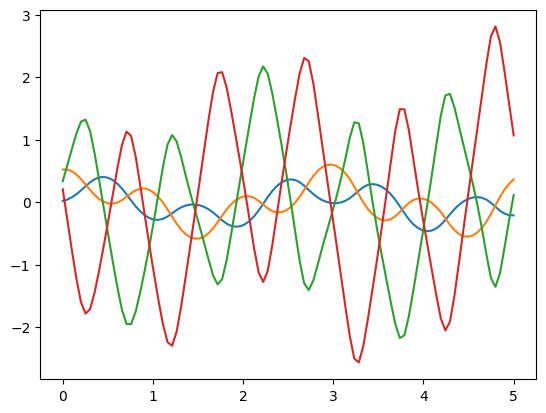

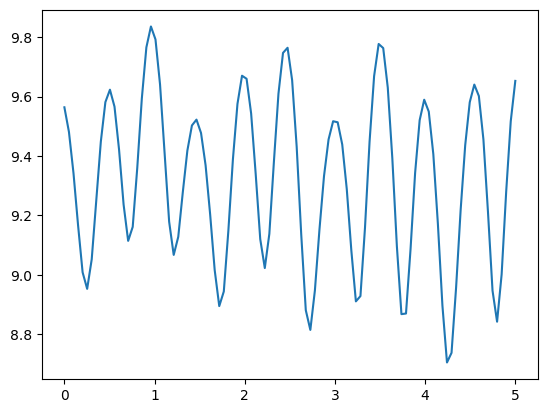

In [ ]:
# simulation
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

trial = num_trials - 1

c_nn.load_state_dict(torch.load("./model/danieljh_sym_c_dp_sep_sc_2t_lr_{}".format(trial), map_location="cpu"))
c_nn.eval()
h_nn.load_state_dict(torch.load("./model/danieljh_sym_h_dp_sep_sc_2t_lr_{}".format(trial), map_location="cpu"))
h_nn.eval()
teval = torch.linspace(0.0,5.0,100)

# initial value: (q1, q2, v1, v2)
x0 = (0.01825532, 0.52412613, 0.33688556, 0.20706259)

print(np.array(x0))
dt = teval[1]-teval[0]
teval = teval.detach().cpu().numpy()
A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
h_nn.cpu()
c_nn.cpu()

def fvec_np(x, t): 
  tx = torch.tensor(x, dtype=torch.float).unsqueeze(0)  
  x = torch.matmul(tx, torch.inverse(B))
  output = h_nn.grad(x)
  jac = c_nn.jac(x)
  jac_t = torch.transpose(jac,1,2)
  M_t = jac - jac_t
  M_inv_t = torch.inverse(M_t).squeeze(1).cpu()

  output = output.unsqueeze(2)
  output = torch.matmul(M_inv_t, output)
  output = torch.matmul(A, output)
  output = output.squeeze(2)
  output = output.squeeze(0)

  return output.detach().cpu().numpy()

res = scipy.integrate.odeint(fvec_np, x0, teval)

sym_x = res.copy()

plt.plot(teval,res[:,0])
plt.plot(teval,res[:,1])
plt.plot(teval,res[:,2])
plt.plot(teval,res[:,3])
plt.show()

def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = h_nn(x).squeeze(0)
  return ne.detach().cpu().numpy()

net_energy = net_energy(res, teval).reshape((100))
plt.plot(teval,net_energy)
plt.show()
  

In [ ]:
def Hamiltonian_qv(state):
    """
    Based on the given state vector (q1, q2, v1, v2), 
    computes the total energy (Hamiltonian) of the double-pendulum system.

    Here:
    q1 = theta1 (Angle 1)
    q2 = theta2 (Angle 2)
    v1 = omega1 (Angular Velocity 1)
    v2 = omega2 (Angular Velocity 2)
    """
    theta1 = state[:,0]
    theta2 = state[:,1]
    omega1 = state[:,2]
    omega2 = state[:,3]
    
    # --- Kinetic Energy ---   
    T1 = 0.5 * m1 * (l1 * omega1)**2
    T2 = 0.5 * m2 * (
        (l1 * omega1)**2 + 
        (l2 * omega2)**2 + 
        2 * l1 * l2 * omega1 * omega2 * np.cos(theta1 - theta2)
    )
    kinetic_energy = T1 + T2
    
    # --- Potential Energy ---    
    V1 = -m1 * g * l1 * np.cos(theta1)
    V2 = -m2 * g * (l1 * np.cos(theta1) + l2 * np.cos(theta2))
    potential_energy = V1 + V2

    return (kinetic_energy + potential_energy)

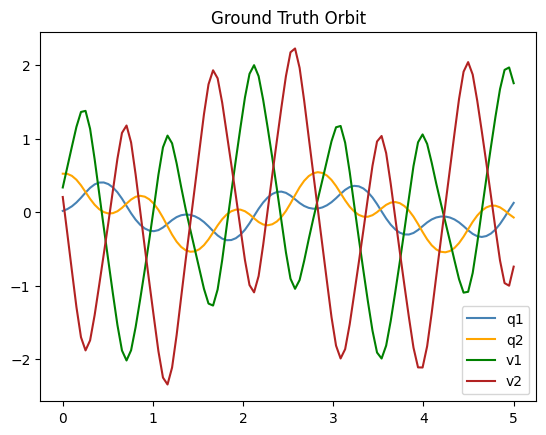

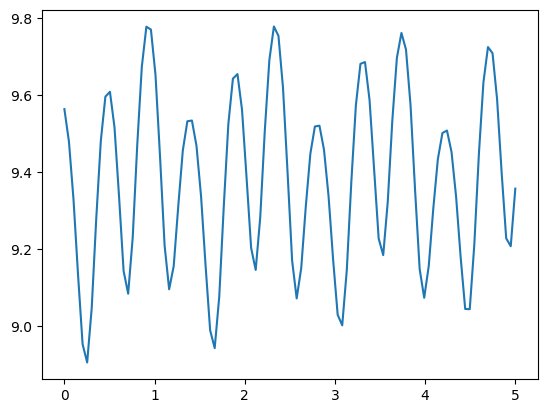

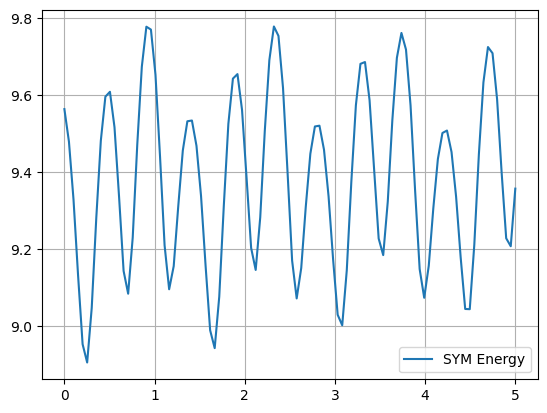

In [ ]:
# Ground truth
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

# equations of motion
def func(t, state):
  cosv = np.cos(state[0]-state[1])
  sinv = np.sin(state[0]-state[1])
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (g*(np.sin(state[1])*cosv - m/m2*np.sin(state[0])) - (l1*state[2]*state[2]*cosv + l2* state[3]*state[3])*sinv) / (l1*(m/m2-cosv*cosv))
  dvdt[3] = (g*m/m2*(np.sin(state[0])*cosv - np.sin(state[1])) + sinv * (l1*state[2]*state[2]*m/m2 + l2* state[3]*state[3]*cosv)) / (l2*(m/m2-cosv*cosv))
  return dvdt

#　the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

state = []
for i in range(1):
  s = (0.01825532, 0.52412613, 0.33688556, 0.20706259 )
  state.append(s)
x0 = state[0]

sol = solver(func, [0, tend], x0, t_eval=t_eval)

tval = sol['t']
true_x = sol['y'].T # (M, 4) [q1, q2, v1, v2]

ax=plt.subplot()
ax.plot(tval, true_x[:, 0], 'steelblue', label='q1')
ax.plot(tval, true_x[:, 1], 'orange', label='q2')
ax.plot(tval, true_x[:, 2], 'g', label='v1')
ax.plot(tval, true_x[:, 3], 'firebrick', label='v2')
ax.legend()
plt.title("Ground Truth Orbit")
plt.show()

def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = h_nn(x).squeeze(0)
  return ne.detach().cpu().numpy()

sym_energy_true_x = net_energy(true_x, teval).reshape((100))
plt.plot(teval,sym_energy_true_x)
plt.show()
plt.plot(tval,sym_energy_true_x, label='SYM Energy')
plt.legend()
plt.grid(True)
plt.show()

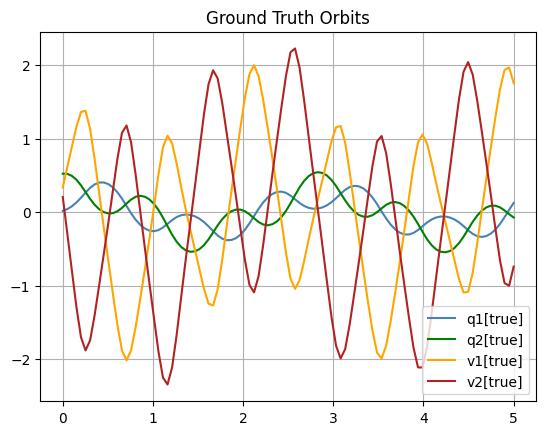

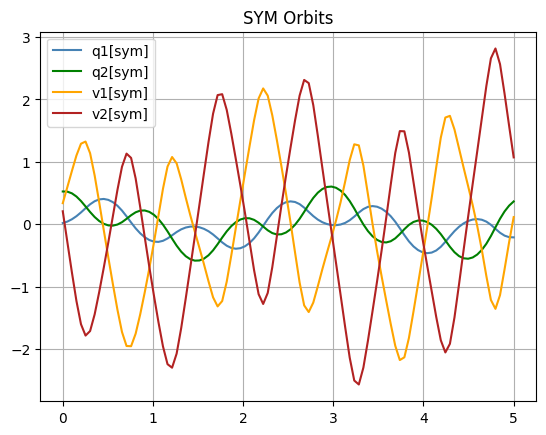

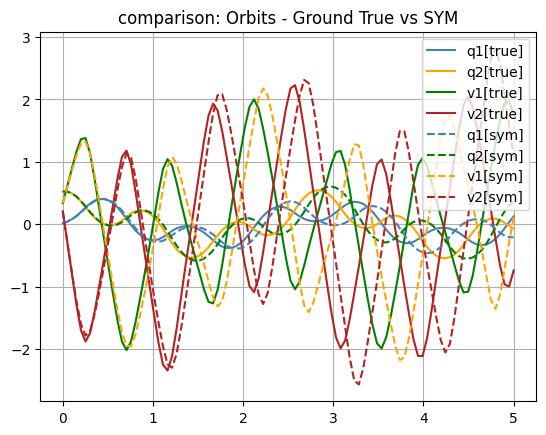

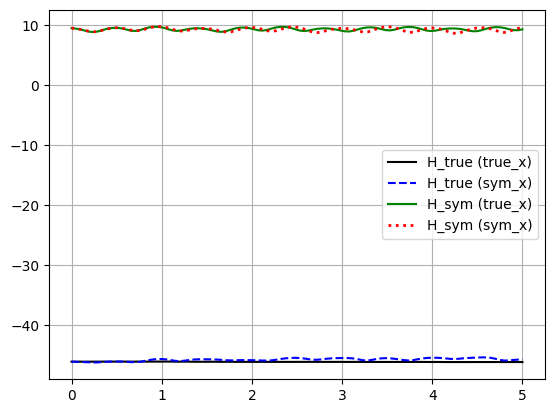

In [14]:
plt.title("Ground Truth Orbits")
plt.plot(tval, true_x[:,0], 'steelblue', label='q1[true]', linestyle='-')
plt.plot(tval, true_x[:,1], 'g', label='q2[true]', linestyle='-')
plt.plot(tval, true_x[:,2], 'orange', label='v1[true]', linestyle='-')
plt.plot(tval, true_x[:,3], 'firebrick', label='v2[true]', linestyle='-')
plt.grid(True)
plt.legend()
plt.show()

plt.title("SYM Orbits")
plt.plot(tval, sym_x[:,0], 'steelblue', label='q1[sym]', linestyle='-')
plt.plot(tval, sym_x[:,1], 'g', label='q2[sym]', linestyle='-')
plt.plot(tval, sym_x[:,2], 'orange', label='v1[sym]', linestyle='-')
plt.plot(tval, sym_x[:,3], 'firebrick', label='v2[sym]',linestyle='-')
plt.grid(True)
plt.legend()
plt.show()

plt.title("comparison: Orbits - Ground True vs SYM")
plt.plot(tval, true_x[:,0], 'steelblue', label='q1[true]', linestyle='-')
plt.plot(tval, true_x[:,1], 'orange', label='q2[true]', linestyle='-')
plt.plot(tval, true_x[:,2], 'g', label='v1[true]', linestyle='-')
plt.plot(tval, true_x[:,3], 'firebrick', label='v2[true]', linestyle='-')
plt.plot(tval, sym_x[:,0], 'steelblue', label='q1[sym]', linestyle='--')
plt.plot(tval, sym_x[:,1], 'g', label='q2[sym]', linestyle='--')
plt.plot(tval, sym_x[:,2], 'orange', label='v1[sym]', linestyle='--')
plt.plot(tval, sym_x[:,3], 'firebrick', label='v2[sym]',linestyle='--')
plt.grid(True)
plt.legend()
plt.show()

sym_energy_sym_x = net_energy(sym_x, teval).reshape((100))
sym_energy_true_x = net_energy(true_x, teval).reshape((100))
true_energy_sym_x = Hamiltonian_qv(sym_x)
true_energy_true_x = Hamiltonian_qv(true_x)

plt.plot(teval,true_energy_true_x, label='H_true (true_x)', color='k', linestyle='-')
plt.plot(teval,true_energy_sym_x, label='H_true (sym_x)', color='b',linestyle='--')
plt.plot(teval,sym_energy_true_x, label='H_sym (true_x)', color='g', linestyle='-', lw=1.5)
plt.plot(teval,sym_energy_sym_x, label='H_sym (sym_x)', color='r', linestyle=':', lw=2)
plt.legend()
plt.grid(True)
plt.show()